In [89]:
import sys
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

from pandas.api.types import is_numeric_dtype

from sklearn.svm import SVC
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, f_classif

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing
from sklearn import utils

from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus
from mlxtend.plotting import plot_decision_regions

sys.path.append("../tools/")

#from feature_format import featureFormat, targetFeatureSplit
#from tester import dump_classifier_and_data

%matplotlib inline

In [90]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)
    
    
### Load the dictionary containing the processed text from the emails
### Code is in vectorize_text.py - heavily borrowed from the scripts used in the text learning module
## as well as the email_preprocess module
with open("email_text.pkl", "rb") as data_file:
    email_dict = pickle.load(data_file)    

In [91]:
##convert dictionary to dataframe for easier manipulation

df = pd.DataFrame.from_dict(data_dict, orient="index")


for x, y in email_dict.items():
    email_dict[x] = ''.join(y)

df_email_text = pd.DataFrame.from_dict(email_dict,orient="index")

df_email_text.rename(index=str,columns={0:'email_text'}, inplace=True)

In [92]:
df = pd.merge(left=df,right=df_email_text,how='left',left_on='email_address',right_index=True)

In [93]:
    
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','bonus','loan_advances'] # You will need to use more features

In [94]:
### Task 2: Remove outliers
#fillna did not work (likely due to NaN being strings, not np.nan), so use replace
df.replace("NaN",0,inplace=True)

df.drop("TOTAL", inplace = True)

df.poi = df.poi.astype(int)

df.drop(columns=['email_address'],inplace=True)

In [95]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = df.to_dict()

### Extract features and labels from dataset for local testing
#data = featureFormat(my_dataset, features_list, sort_keys = True)
#labels, features = targetFeatureSplit(data)

In [95]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = df.to_dict()

### Extract features and labels from dataset for local testing
#data = featureFormat(my_dataset, features_list, sort_keys = True)
#labels, features = targetFeatureSplit(data)

In [95]:



### text vectorization--go from strings to lists of numbers
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.85,
                             stop_words='english',max_features=10000)
features_train_transformed = vectorizer.fit_transform(features_train)
features_test_transformed  = vectorizer.transform(features_test)
terms = vectorizer.get_feature_names()


### feature selection, because text is super high dimensional and 
### can be really computationally chewy as a result
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(features_train_transformed, labels_train)
features_train = selector.transform(features_train_transformed).toarray()
features_test  = selector.transform(features_test_transformed).toarray()


## https://stackoverflow.com/questions/41724432/ml-getting-feature-names-after-feature-selection-selectpercentile-python
## https://stackoverflow.com/questions/9296658/how-to-filter-a-numpy-array-using-another-arrays-values

support = np.asarray(selector.get_support(),'bool')

terms = np.asarray(terms)

selected_feature_names = terms[support]


##https://stackoverflow.com/questions/30653642/combining-bag-of-words-and-other-features-in-one-model-using-sklearn-and-pandas


In [96]:
## process data
## process_data function accepts a few different arguments, allowing me to scale, resample, and filter the features
## https://elitedatascience.com/imbalanced-classes

def process_data(data,label_column='poi',scale=0,rsmpl=0,feature_list=None):    
    ##Resample first, if needed
    ##https://stackoverflow.com/questions/52735334/python-pandas-resample-dataset-to-have-balanced-classes    
    
    if rsmpl:
        
        df_majority = data[data[label_column]==0]
        df_minority = data[data[label_column]==1]

        # Upsample minority class
        df_minority_upsampled = utils.resample(df_minority,
                                         n_samples=50,
                                         replace=True     # sample with replacement
                                        )

        # Combine majority class with upsampled minority class
        data = pd.concat([df_majority, df_minority_upsampled,df_minority])
                
    ##separate features from labels
    
    features = data.drop(columns=[label_column])
    labels = data[label_column]      
    
    if feature_list:
        features = features[feature_list]          
        
    if scale:
        for x in features.columns:
            if is_numeric_dtype(features[x]):
                features[x] = preprocessing.scale(features[x])        
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify=labels)
    
    return X_train, X_test, y_train, y_test

In [97]:
X_train, X_test, y_train, y_test = process_data(df,rsmpl=1)#, feature_list=['bonus','total_stock_value','other'])

In [102]:
## https://machinelearningmastery.com/feature-selection-machine-learning-python/

# Feature Importance with Extra Trees Classifier

# load data
et_clf = ExtraTreesClassifier()
et_clf.fit(X_train, y_train)

fs = et_clf.feature_importances_

df_feature_importance = pd.DataFrame(fs,index=feature_labels)

df_feature_importance.sort_values(by=0, ascending=False)

C:\Users\jcsmi329\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [99]:


if 'email_text' in X_train.columns:
    
    df_X_train_email = pd.DataFrame(X_train_email,columns=selected_feature_names)
    df_X_test_email = pd.DataFrame(X_test_email,columns=selected_feature_names)

    X_train = X_train.join(df_X_train_email,rsuffix='et_')
    X_test = X_test.join(df_X_test_email,rsuffix='et_')


    X_train.drop(columns=['email_text'], inplace=True)
    X_test.drop(columns=['email_text'], inplace=True)



In [96]:
## process data
## process_data function accepts a few different arguments, allowing me to scale, resample, and filter the features
## https://elitedatascience.com/imbalanced-classes

def process_data(data,label_column='poi',scale=0,rsmpl=0,feature_list=None):    
    ##Resample first, if needed
    ##https://stackoverflow.com/questions/52735334/python-pandas-resample-dataset-to-have-balanced-classes    
    
    if rsmpl:
        
        df_majority = data[data[label_column]==0]
        df_minority = data[data[label_column]==1]

        # Upsample minority class
        df_minority_upsampled = utils.resample(df_minority,
                                         n_samples=50,
                                         replace=True     # sample with replacement
                                        )

        # Combine majority class with upsampled minority class
        data = pd.concat([df_majority, df_minority_upsampled,df_minority])
                
    ##separate features from labels
    
    features = data.drop(columns=[label_column])
    labels = data[label_column]      
    
    if feature_list:
        features = features[feature_list]          
        
    if scale:
        for x in features.columns:
            if is_numeric_dtype(features[x]):
                features[x] = preprocessing.scale(features[x])        
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify=labels)
    
    return X_train, X_test, y_train, y_test

In [97]:
X_train, X_test, y_train, y_test = process_data(df,rsmpl=1)#, feature_list=['bonus','total_stock_value','other'])

In [100]:
X_test = X_test.fillna(0)
X_train = X_train.fillna(0)

feature_labels = X_train.columns

In [110]:
print(feature_labels,fs)

Index(['salary', 'to_messages', 'deferral_payments', 'total_payments',
       'loan_advances', 'bonus', 'restricted_stock_deferred',
       'deferred_income', 'total_stock_value', 'expenses',
       ...
       'zimin', 'ziminvkaminsnsf', 'zip', 'zipper', 'zippercorpenronenron',
       'zipter', 'zkhokhermailutexasedu', 'zochnaenronenron', 'zuffer',
       'zufferlicalectect'],
      dtype='object', length=8019) [0.04266419 0.07180271 0.06126955 ... 0.         0.         0.        ]


In [102]:
## https://machinelearningmastery.com/feature-selection-machine-learning-python/

# Feature Importance with Extra Trees Classifier

# load data
et_clf = ExtraTreesClassifier()
et_clf.fit(X_train, y_train)

fs = et_clf.feature_importances_

df_feature_importance = pd.DataFrame(fs,index=feature_labels)

df_feature_importance.sort_values(by=0, ascending=False)

C:\Users\jcsmi329\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [98]:
## Using the email text worked well when I was using only the emails
## However, when I eventually got to adding the email text to this dataset
## My performance went way down - the reason is likely twofolder
## First - the email text had over ten thousand emails, giving the classifier a lot more data
## Second - the dataset here has multiple rows with no email addresses, which causes some imbalance
## I ended up removing the email_text from the selected features

if 'email_text' in X_train.columns:

    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.85,
                                 stop_words='english',max_features=10000)

    X_train_email_transformed = vectorizer.fit_transform(X_train['email_text'].fillna(''))
    X_test_email_transformed  = vectorizer.transform(X_test['email_text'].fillna(''))
    terms = vectorizer.get_feature_names()


    ### feature selection, because text is super high dimensional and 
    ### can be really computationally chewy as a result
    selector = SelectPercentile(f_classif, percentile=80)
    selector.fit(X_train_email_transformed, y_train)
    X_train_email = selector.transform(X_train_email_transformed).toarray()
    X_test_email  = selector.transform(X_test_email_transformed).toarray()


    ## https://stackoverflow.com/questions/41724432/ml-getting-feature-names-after-feature-selection-selectpercentile-python
    ## https://stackoverflow.com/questions/9296658/how-to-filter-a-numpy-array-using-another-arrays-values

    support = np.asarray(selector.get_support(),'bool')

    terms = np.asarray(terms)

    selected_feature_names = terms[support]


    ##https://stackoverflow.com/questions/30653642/combining-bag-of-words-and-other-features-in-one-model-using-sklearn-and-pandas


In [99]:


if 'email_text' in X_train.columns:
    
    df_X_train_email = pd.DataFrame(X_train_email,columns=selected_feature_names)
    df_X_test_email = pd.DataFrame(X_test_email,columns=selected_feature_names)

    X_train = X_train.join(df_X_train_email,rsuffix='et_')
    X_test = X_test.join(df_X_test_email,rsuffix='et_')


    X_train.drop(columns=['email_text'], inplace=True)
    X_test.drop(columns=['email_text'], inplace=True)



In [82]:
## Pulled in the GaussianNB classifier when attempting to use text data
## Ended up removing the text, but this still gives pretty decent results

gb = GaussianNB()

gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)

cr = classification_report(y_test, y_pred)

print(gb.score(X_test,y_test))
print(cr)

0.4489795918367347
              precision    recall  f1-score   support

           0       0.73      0.25      0.37        32
           1       0.37      0.82      0.51        17

   micro avg       0.45      0.45      0.45        49
   macro avg       0.55      0.54      0.44        49
weighted avg       0.60      0.45      0.42        49



0.673469387755102
              precision    recall  f1-score   support

           0       0.72      0.81      0.76        32
           1       0.54      0.41      0.47        17

   micro avg       0.67      0.67      0.67        49
   macro avg       0.63      0.61      0.62        49
weighted avg       0.66      0.67      0.66        49



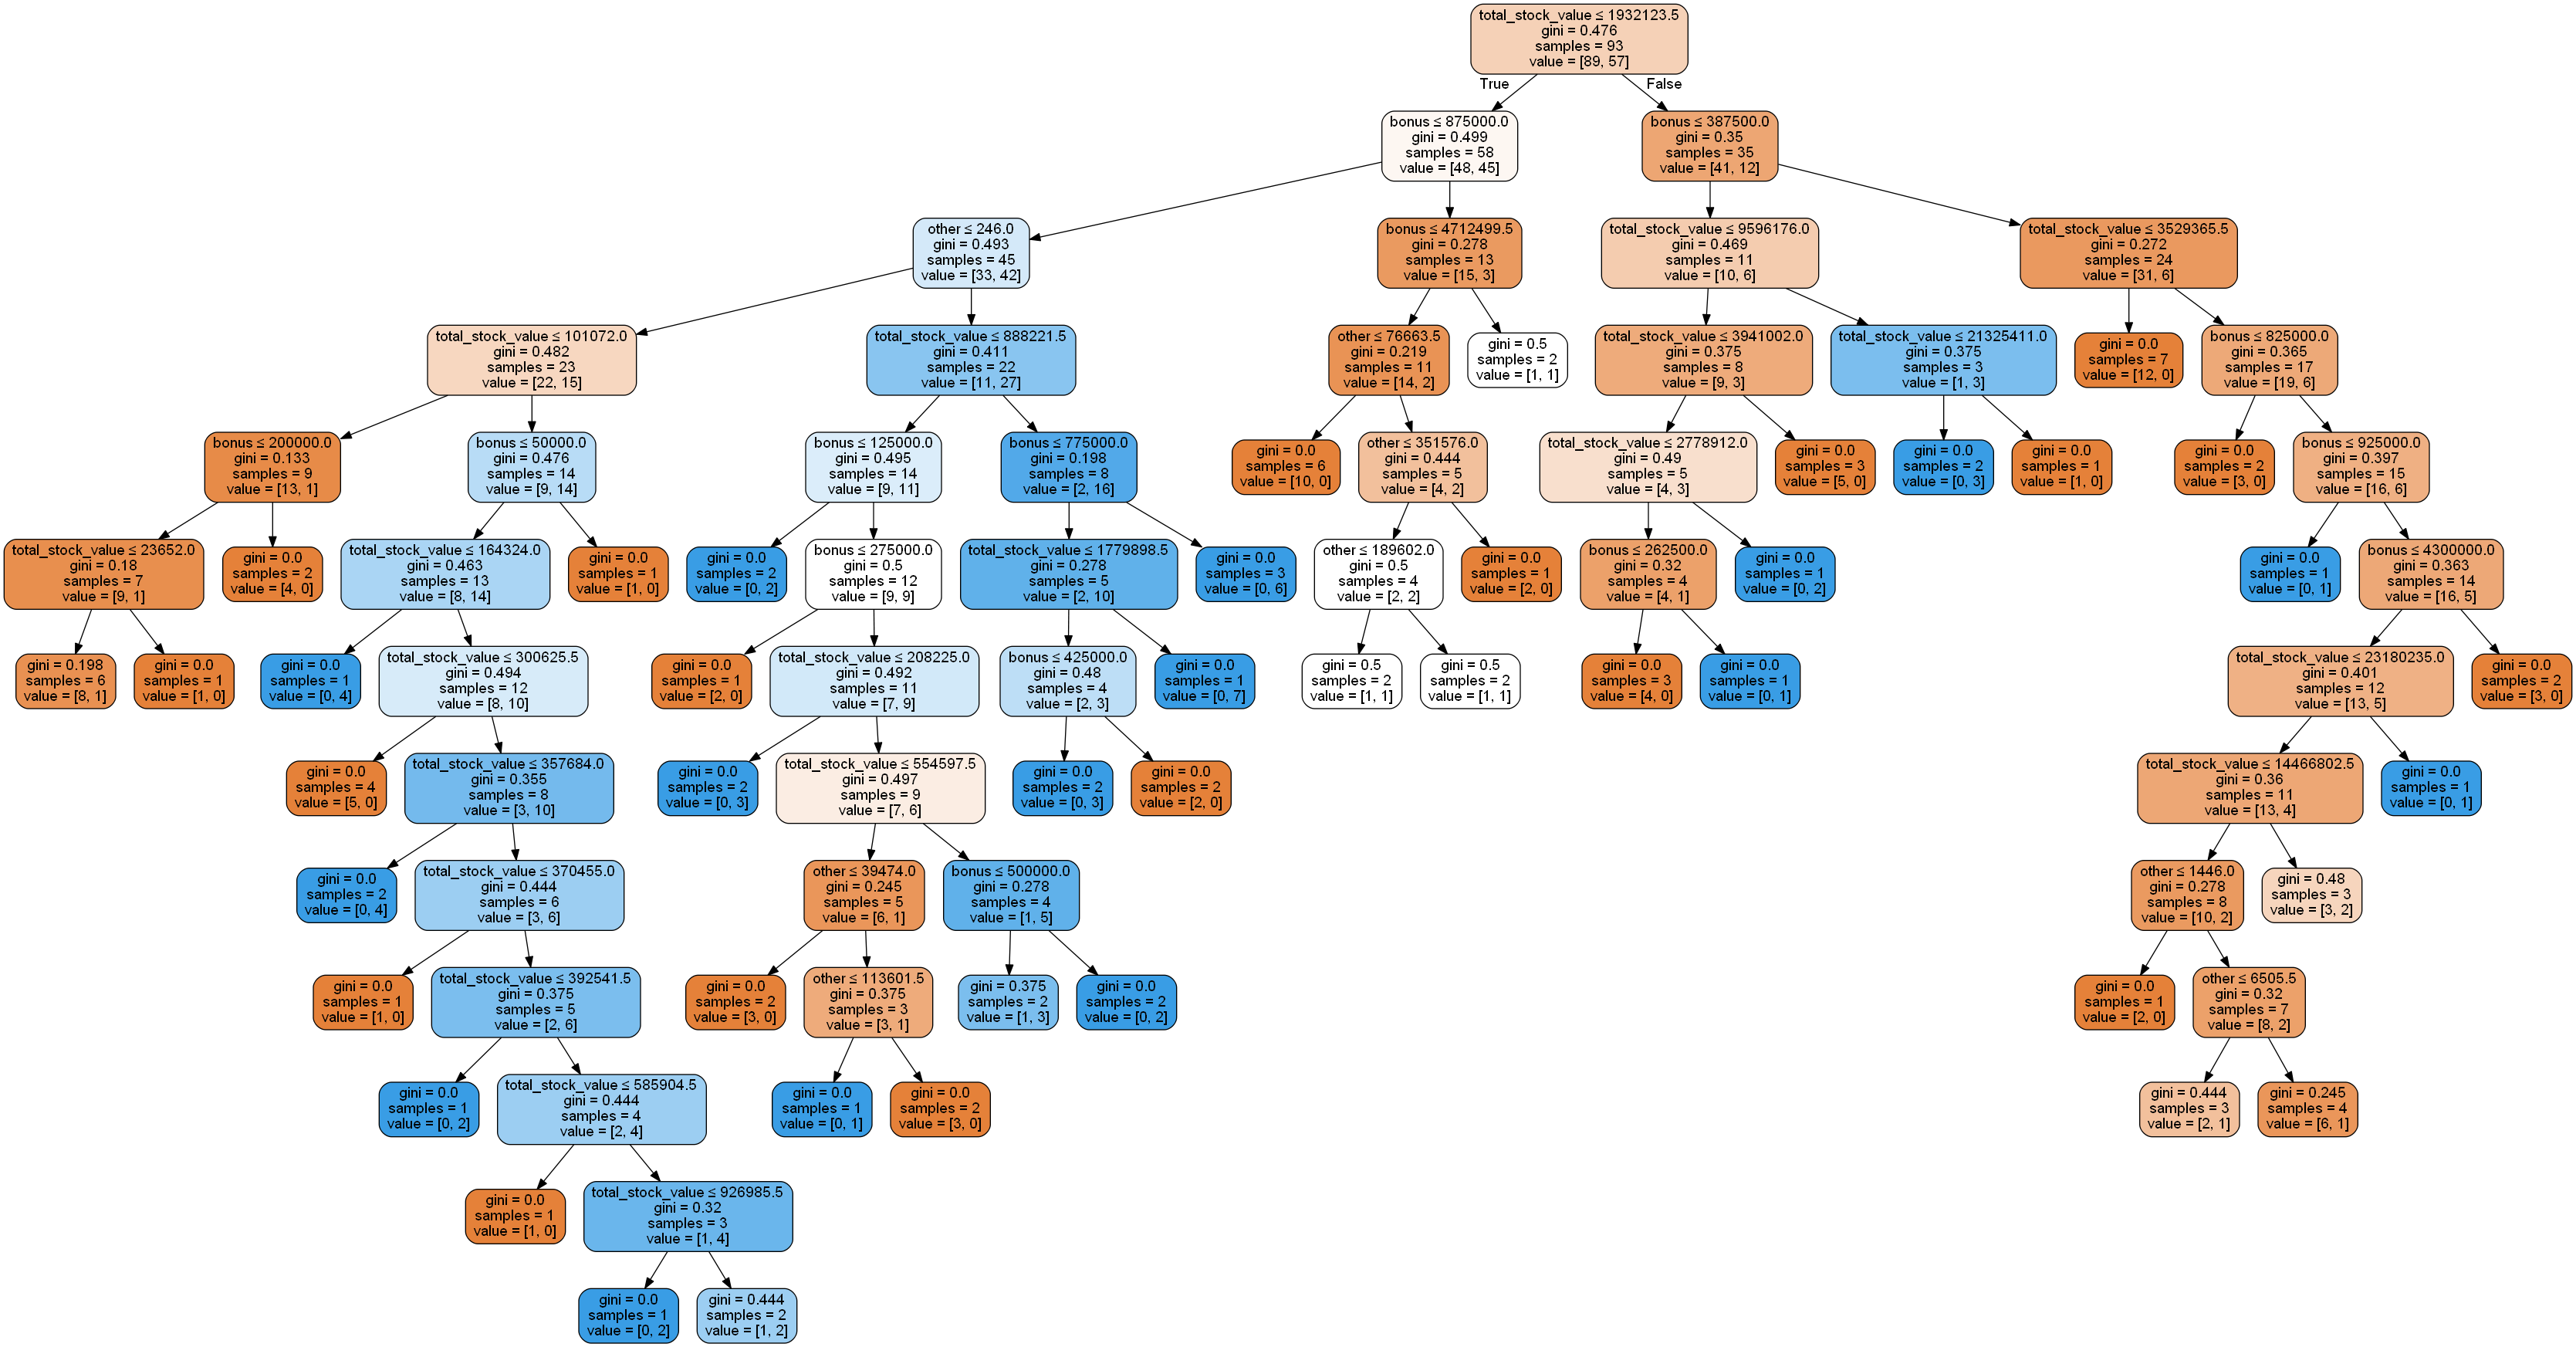

In [86]:
##https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

rf_clf = None

rf_clf = RandomForestClassifier(min_samples_split=3, n_estimators=150, random_state = 12)

rf_clf.fit(X_train,y_train)


y_pred = rf_clf.predict(X_test)

cr = classification_report(y_test, y_pred)

print(rf_clf.score(X_test,y_test))
print(cr)


dot_data = StringIO()
export_graphviz(rf_clf.estimators_[1], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True
               ,feature_names =feature_labels)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [87]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!

clf = SVC(kernel='sigmoid',C=1000,gamma='scale',random_state=12)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print(round(clf.score(X_test,y_test),2))
cr = classification_report(y_test, y_pred)

print(cr)

0.61
              precision    recall  f1-score   support

           0       0.69      0.75      0.72        32
           1       0.43      0.35      0.39        17

   micro avg       0.61      0.61      0.61        49
   macro avg       0.56      0.55      0.55        49
weighted avg       0.60      0.61      0.60        49



0.6938775510204082
              precision    recall  f1-score   support

           0       0.73      0.84      0.78        32
           1       0.58      0.41      0.48        17

   micro avg       0.69      0.69      0.69        49
   macro avg       0.66      0.63      0.63        49
weighted avg       0.68      0.69      0.68        49



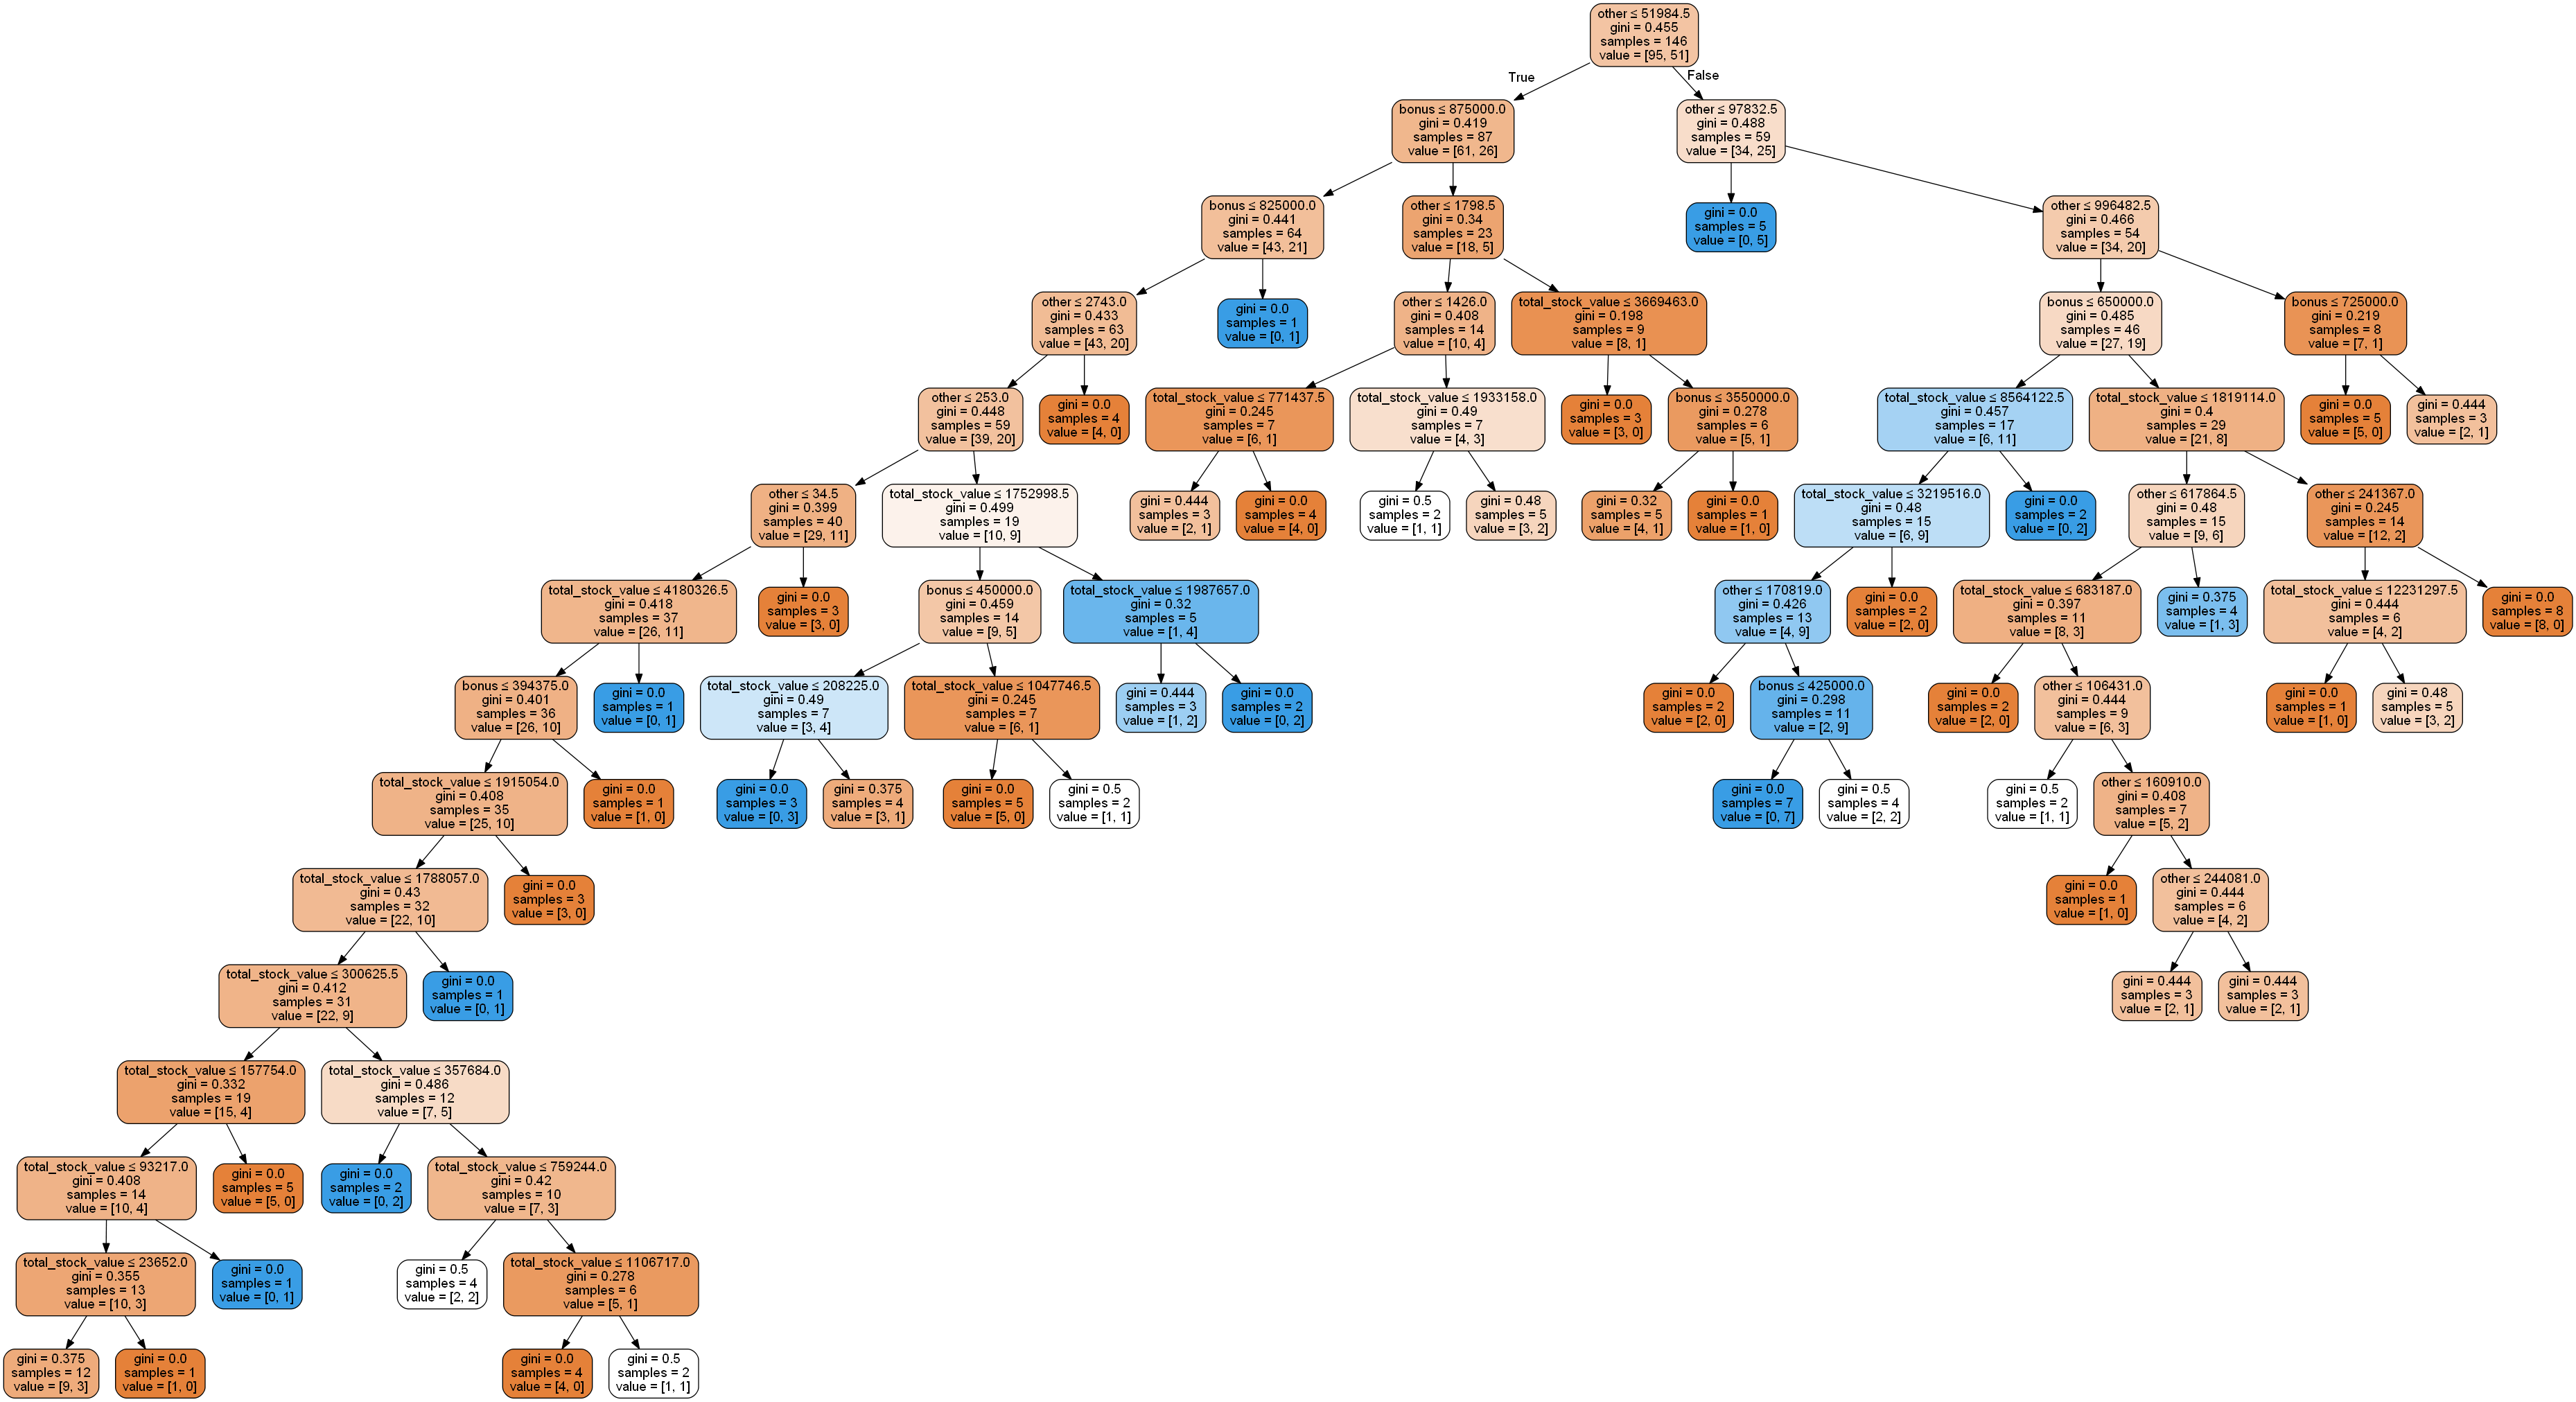

In [85]:
dt_clf = tree.DecisionTreeClassifier(min_samples_split=5,max_features=2,random_state=40)

dt_clf.fit(X_train,y_train)

dt_clf.score(X_test,y_test)

y_pred = dt_clf.predict(X_test)

print(dt_clf.score(X_test,y_test))
cr = classification_report(y_test, y_pred)

print(cr)

dot_data = StringIO()
export_graphviz(dt_clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True
               ,feature_names =feature_labels)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [102]:
## https://machinelearningmastery.com/feature-selection-machine-learning-python/

# Feature Importance with Extra Trees Classifier

# load data
et_clf = ExtraTreesClassifier()
et_clf.fit(X_train, y_train)

fs = et_clf.feature_importances_

df_feature_importance = pd.DataFrame(fs,index=feature_labels)

df_feature_importance.sort_values(by=0, ascending=False)

C:\Users\jcsmi329\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [29]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

#dump_classifier_and_data(clf, my_dataset, features_list)

In [113]:
df_feature_importance = pd.DataFrame(fs,index=feature_labels)

df_feature_importance.sort_values(by=0, ascending=False)

,0
total_payments,0.091978
total_stock_value,0.088037
shared_receipt_with_poi,0.075106
exercised_stock_options,0.073545
to_messages,0.071803
other,0.070115
expenses,0.068146
restricted_stock,0.063432
deferral_payments,0.061270
from_this_person_to_poi,0.050880


Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]



##### What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]

I ended up using total_stock_value, bonus, and other. I chose these by running all of the features through a decision tree a few different ways, and selecting the features that were used most often and most accurately by the decision tree. 

I did not do any scaling - I attempted scaling, but found that whenever I did scale the features, my performance suffered. I'm not sure if this is due a technical issue on my end, or the data itself.

I did attempt to engineer features - using the text from the emails in the emails_by_address folder. I did this work in vectorize_text.py file - I copied very heavily from the Text Learning module code, as well as email_preprocess.py from the Naive Bayes module.

The features were to be the top X number of text features from the emails that would improve the model. I used a TfIdf Vectorizer and SelectPercentile with an 80th percentile filter.


What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]

What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric items: “discuss parameter tuning”, “tune the algorithm”]

What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric items: “discuss validation”, “validation strategy”]

Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]
